# Regularizing a deep neural network

## Setup

In [2]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir('..')

print("Current working directory: ", os.getcwd())
if not os.getcwd().endswith("CIFAR-100-DNN-Optimization"):
    raise ValueError("Please change working directory to 'path/CIFAR-100-DNN-Optimization' before proceeding")

Current working directory:  /Users/irellzane/MLprojects/CIFAR-100-DNN-Optimization


In [3]:
!pip install -r requirements.txt

In [4]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [85]:
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [6]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        self.model.optimizer.learning_rate = rate

In [26]:
def plot_history(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.plot(style=["g+--", "ro--", "b*-", "k^-"], alpha=0.8, xlabel="epoch")
    plt.show()

## Load Data

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_pre_path = './data/CIFAR-100/'

In [8]:
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
data_train = data_train_dict[b'data']
y_train_valid = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
y_test = np.array(data_test_dict[b'fine_labels'])

In [9]:
X_train_valid = data_train.reshape(-1, 3, 32, 32).transpose(0,2,3,1) / 255
X_test = data_test.reshape(-1, 3, 32, 32).transpose(0,2,3,1) / 255

In [14]:
input_shape = X_train_valid[0].shape
input_shape

(32, 32, 3)

## Data splitting

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=5000/50000, stratify=y_train_valid, random_state=42)

## Dimensionality Reduction

In [57]:
from sklearn.decomposition import PCA

pca = PCA(0.99)

In [60]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_train_reduced = pca.fit_transform(X_train_flattened)

In [62]:
X_valid_flattened = X_valid.reshape(X_valid.shape[0], -1)
X_valid_reduced = pca.transform(X_valid_flattened)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_test_reduced = pca.transform(X_test_flattened)

In [67]:
input_shape = X_train_reduced[0].shape
input_shape

(659,)

## L2 regularization

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Input(shape=input_shape))

for _ in range(10):
    model.add(Dense(400, activation="swish", kernel_initializer="he_normal", kernel_regularizer=l2(0.001)))
    
model.add(Dense(100, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(nesterov=True, learning_rate=0.05)

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [82]:
n_epochs = 30
batch_size = 128
onecycle = OneCycleScheduler(np.ceil(len(X_train_reduced) / batch_size) * n_epochs,
                             max_rate=0.5)

In [83]:
history = model.fit(
    X_train_reduced, y_train,
    validation_data=(X_valid_reduced, y_valid),
    epochs=n_epochs,
    batch_size=batch_size, 
    callbacks=[onecycle]
)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.0232 - loss: 12.4064 - val_accuracy: 0.0416 - val_loss: 11.6271
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.0711 - loss: 11.2234 - val_accuracy: 0.1136 - val_loss: 10.2063
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1259 - loss: 9.8786 - val_accuracy: 0.1406 - val_loss: 8.9901
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1497 - loss: 8.6629 - val_accuracy: 0.1622 - val_loss: 7.8520
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1707 - loss: 7.5362 - val_accuracy: 0.1620 - val_loss: 6.8712
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1799 - loss: 6.5488 - val_accuracy: 0.1658 - val_loss: 6.0585
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1853 - loss: 5.7378 - val_accuracy: 0.1658 - val_loss: 5.4096
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.1861 - loss: 5.1116 - va

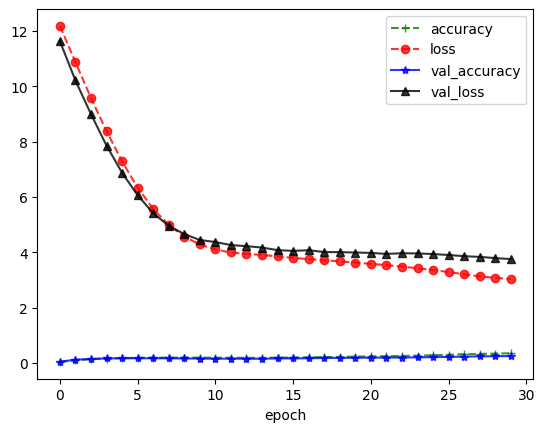

In [84]:
plot_history(history)

In [55]:
model.evaluate(X_valid, y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2256 - loss: 3.6059


[3.5882203578948975, 0.2321999967098236]

In [56]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2427 - loss: 3.5584


[3.5680172443389893, 0.24050000309944153]

## Dropout

In [86]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Input(shape=input_shape))

for _ in range(10):
    model.add(Dropout(rate=0.2))
    model.add(Dense(400, activation="swish", kernel_initializer="he_normal", kernel_regularizer=l2(0.001)))
    
model.add(Dense(100, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(nesterov=True, learning_rate=0.05)

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [87]:
history = model.fit(
    X_train_reduced, y_train,
    validation_data=(X_valid_reduced, y_valid),
    epochs=n_epochs,
    batch_size=batch_size, 
    callbacks=[onecycle]
)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.0088 - loss: nan - val_accuracy: 0.0100 - val_loss: nan
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.0106 - loss: nan - val_accuracy: 0.0100 - val_loss: nan
Epoch 3/30
151/352 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0111 - loss: nan

KeyboardInterrupt: 